# Quantum Time Series Analysis: CNN Model
Compatible with scikit-learn 1.5.2+

### Author
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022

### Aims
> *This script aims to fit time series data with a classical quantum neural network.*

### Note
> *<font color="tomato">When running this script, you are likely to obtain slightly different results each time.</font>*

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/qiskit-gpu/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/site-packages',
 '.']

In [2]:
import os
import numpy as np
import pylab
import math
import json
import time
from tqdm.notebook import tqdm

from IPython.display import clear_output

from utils.Target import *
from utils.Window import *
from utils.TS import *
from utils.Charts import *
from utils.Files import *
from utils.Cost import *
from utils.Metrics import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
### Libraries used in QTSA development

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

In [4]:
### Listing control
debug = True
seed = 2022

### Software version
MAJOR = 9
MINOR = 0

### Constants
LOG_NAME = 'log_2'
CASE_NAME = 'cnn'
DATA_NAME = '2_sins_sw'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_2',
 'cnn',
 '2_sins_sw',
 'log_2/data',
 'log_2/training',
 'log_2/params',
 'log_2/analysis',
 'log_2/figures')

## Fetch data

In [5]:
### All created files have the following codes:
DATA_ID = '2_sins_sw_t50_v20_z0_w5_s1_h1'

### Define file names

x_all_fpath = f'{DATA_PATH}/{DATA_ID}/x_all.arr'
y_all_fpath = f'{DATA_PATH}/{DATA_ID}/y_all.arr'

x_train_ts_fpath = f'{DATA_PATH}/{DATA_ID}/x_train_ts.arr'
y_train_ts_fpath = f'{DATA_PATH}/{DATA_ID}/y_train_ts.arr'
x_valid_ts_fpath = f'{DATA_PATH}/{DATA_ID}/x_valid_ts.arr'
y_valid_ts_fpath = f'{DATA_PATH}/{DATA_ID}/y_valid_ts.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_ID}/info.json'
data_info_fpath

'log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json'

In [6]:
### Load the info file
data_info = read_json_file(data_info_fpath)
    
### Get info details
DATA_NAME = data_info['data_name']
DATA_MAJOR = data_info['major_version'] 
DATA_MINOR = data_info['minor_version']
samples_train = data_info['data_train']
samples_valid = data_info['data_valid']
noise = data_info['data_noise']
wind_size = data_info['wind_size']
wind_step = data_info['wind_step']
horizon = data_info['wind_horizon']
seed = data_info['seed']
samples = samples_train + samples_valid
train_pc = samples_train / samples

print(f'\nSaved time series info in file "{data_info_fpath}":\n')
for k in data_info.keys():
    print(f'\tinfo[{k}] = {data_info[k]}')
print()
print(f'\tcalc[samples] = {samples}')
print(f'\tcalc[train_pc] = {train_pc}')
print()


Saved time series info in file "log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json":

	info[data_name] = 2_sins_sw
	info[major_version] = 9
	info[minor_version] = 0
	info[data_train] = 50
	info[data_valid] = 20
	info[data_noise] = 0
	info[wind_size] = 5
	info[wind_step] = 1
	info[wind_horizon] = 1
	info[seed] = 2022

	calc[samples] = 70
	calc[train_pc] = 0.7142857142857143



In [7]:
### Load data files
X_all = read_ts_file(x_all_fpath)[..., None]
y_all = read_ts_file(y_all_fpath)
X_train_ts = read_ts_file(x_train_ts_fpath)
y_train_ts = read_ts_file(y_train_ts_fpath)[..., None]
X_valid_ts = read_ts_file(x_valid_ts_fpath)
y_valid_ts = read_ts_file(y_valid_ts_fpath)[..., None]
print(f'\nLoaded time series data\n')


Loaded time series data



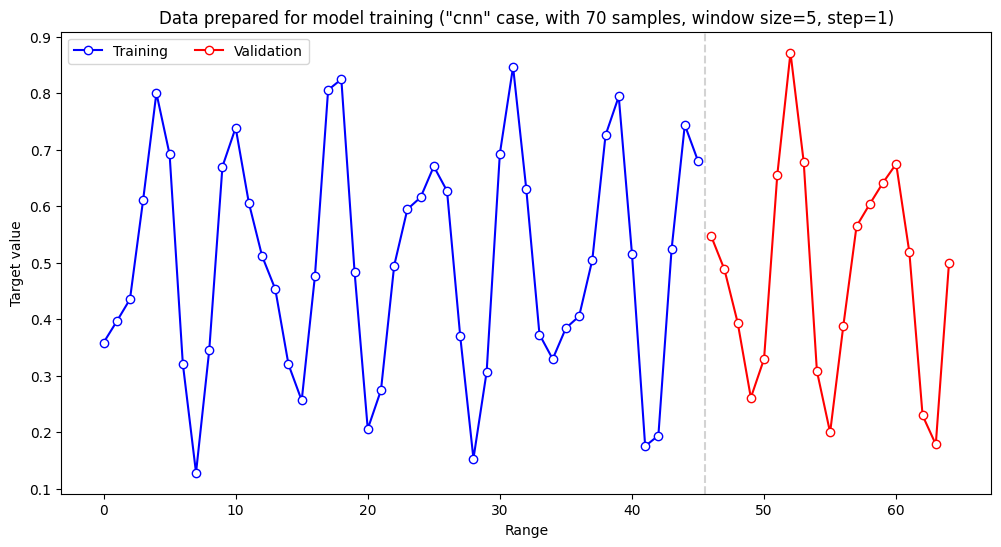

In [8]:
### Plot trainig and validation/test data partitions
#   Note that we will not use the X coordinates

y_train_flat_ts = ts_wind_flatten_avg(y_train_ts, wind_step)
y_valid_flat_ts = ts_wind_flatten_avg(y_valid_ts, wind_step)
y_list = [y_train_flat_ts, y_valid_flat_ts]
X_list = [0, len(y_train_flat_ts)]

print()
multi_plot_flat_ts(y_list, X_list=X_list, 
    colors = ['blue', 'red'], marker_colors=['white', 'white', 'lightblue', 'mistyrose'],
    labels = ['Training', 'Validation'], #ylim=(0.1, 1),
    lines = ['solid', 'solid'], markers = ['o', 'o'], legend_cols=2,
    title=f'Data prepared for model training ("{CASE_NAME}" case, with {samples} samples, window size={wind_size}, step={wind_step})')
print()

## Utilities

In [9]:
def plot(objfun_vals, title='Objective function value', xlabel='Iteration', ylabel='Cost', col='blue', log_interv=1, save_plot=None):
    clear_output(wait=True)
    min_cost = min(obj_fun_vals)
    min_x = np.argmin(obj_fun_vals)*log_interv
    x_vals = [x*log_interval for x in range(len(objfun_vals))]
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title(f'{title} (min: {np.round(min_cost, 4)} @ {min_x})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_vals, objfun_vals, color=col)
    
    if save_plot is not None:
        os.makedirs(os.path.dirname(save_plot), exist_ok=True)
        plt.savefig(save_plot, format='eps')
    plt.show()

## Classical MLP Solution (sklearn)

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 

### Produce the results with best max_iter
estimator = MLPRegressor(hidden_layer_sizes=(150,100,50), random_state=2022, max_iter=850, activation = 'relu',
                       solver = 'lbfgs', shuffle=True)
estimator.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (150, 100, 50),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 850,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 2022,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [11]:
### Train and score the model
regr = estimator.fit(X_train_ts, y_train_ts.reshape(y_train_ts.shape[0],))
yp_train_hat = regr.predict(X_train_ts)
yp_valid_hat = regr.predict(X_valid_ts)

# Score the model
train_r2 = np.round(r2_score(y_train_ts, yp_train_hat), 6)
train_mae = np.round(mean_absolute_error(y_train_ts, yp_train_hat), 6)
train_mse = np.round(mean_squared_error(y_train_ts, yp_train_hat), 6)
print(f'\nTraining   R2:\t{train_r2:0.6f}\nTraining   MAE:\t{train_mae:0.6f}\nTraining   MSE:\t{train_mse:0.6f}')

test_r2 = np.round(r2_score(y_valid_ts, yp_valid_hat), 6)
test_mae = np.round(mean_absolute_error(y_valid_ts, yp_valid_hat), 6)
test_mse = np.round(mean_squared_error(y_valid_ts, yp_valid_hat), 6)
print(f'\nValidation R2:\t{test_r2:0.6f}\nValidation MAE:\t{test_mae:0.6f}\nValidation MSE:\t{test_mse:0.6f}\n')


Training   R2:	0.999615
Training   MAE:	0.002960
Training   MSE:	0.000015

Validation R2:	0.999576
Validation MAE:	0.003313
Validation MSE:	0.000015



In [12]:
def n_params(model):
    return (sum([a.size for a in model.coefs_]) +  
            sum([a.size for a in model.intercepts_]))
print(f'\nThe number of sklearn model parameters: {n_params(estimator)}\n')


The number of sklearn model parameters: 21101



In [13]:
### Training parameters

### All created files have the following codes:
#   n: sample size
#   z: level of noise injected
#   q: number of qubits
#   fm: number of fm layers
#   anz: number of ansatz layers
#   opt_name: name of the optimiser
#   ep: number of "maxiter" epochs
opt_name = estimator.get_params()['solver']
model_lays = estimator.get_params()['hidden_layer_sizes']
max_iter = estimator.get_params()['max_iter']
model_descr = '_'.join([f'{i:03d}' for i in model_lays])
CANALYSIS_PREF = f'cnn_n{samples}_z{noise}_hl{model_descr}_'+\
             f'{opt_name}_'+\
             f'ep{max_iter}'
CANALYSIS_PREF

'cnn_n70_z0_hl150_100_050_lbfgs_ep850'

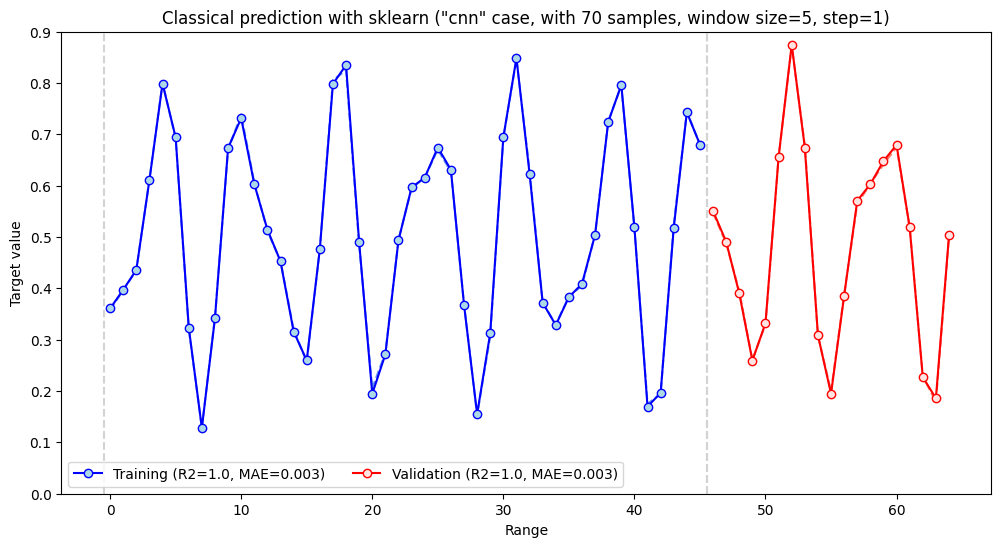

In [14]:
### Plot trainig and validation/test data partitions
#   Note that we will not use the X coordinates

y_train_flat_ts = ts_wind_flatten_avg(y_train_ts, wind_step)
y_train_hat_flat_ts = ts_wind_flatten_avg(yp_train_hat.reshape(y_train_ts.shape), wind_step)
y_valid_flat_ts = ts_wind_flatten_avg(y_valid_ts, wind_step)
y_valid_hat_flat_ts = ts_wind_flatten_avg(yp_valid_hat.reshape(y_valid_ts.shape), wind_step)

y_list = [y_train_flat_ts, y_valid_flat_ts, y_train_hat_flat_ts, y_valid_hat_flat_ts]
X_list = [0, len(y_train_flat_ts), 0, len(y_train_flat_ts)]

print()
multi_plot_flat_ts(y_list, X_list=X_list, legend_cols=2, ylim=(0, 0.9),
    colors = ['cornflowerblue', 'salmon', 'blue', 'red'], 
    marker_colors=['white', 'white', 'lightblue', 'mistyrose'],
    labels=['', '', f'Training (R2={np.round(train_r2, 3)}, MAE={np.round(train_mae, 3)})', f'Validation (R2={np.round(test_r2, 3)}, MAE={np.round(test_mae, 3)})'],
    lines = ['dashed', 'dashed', 'solid', 'solid'], 
    markers = ['none', 'none', 'o', 'o'],
    title=f'Classical prediction with sklearn ("{CASE_NAME}" case, with {samples} samples, window size={wind_size}, step={wind_step})',
    save_plot=f'{FIGURES_PATH}/analz_{CANALYSIS_PREF}/sklearn_fit.eps'
)
print()

## System

In [15]:
!pip list | grep -e qiskit -e scikit-learn

qiskit                    1.2.4
qiskit-aer-gpu            0.15.1
qiskit-algorithms         0.3.1
qiskit-ibm-runtime        0.32.0
qiskit-machine-learning   0.7.2
qiskit-optimization       0.6.1
scikit-learn              1.5.2
